In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib.pyplot as plt  # Make sure this line is included
from torch import nn, optim
import torch.nn.functional as F


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import ToPILImage


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Data Loaders
to_pil_image = ToPILImage()
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images for ResNet
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)



100%|███████████████████████| 170498071/170498071 [00:04<00:00, 36287080.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# # Encoder Definition
# class Encoder(nn.Module):
#     # Use a simple architecture; you might want to use something like ResNet for better results.
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc = nn.Linear(64*16*16, 128)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv(x)))
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return nn.functional.normalize(x, dim=1)

# q_encoder = Encoder().to(device)
# k_encoder = Encoder().to(device)
# k_encoder.load_state_dict(q_encoder.state_dict())  # Initialize k_encoder with q_encoder weights


import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc = nn.Linear(512, 128)  # Adjust the dimensions according to your need

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return nn.functional.normalize(x, dim=1)

q_encoder = Encoder().to(device)
k_encoder = Encoder().to(device)
k_encoder.load_state_dict(q_encoder.state_dict())






# Momentum Update
def momentum_update(query, key, momentum=0.999):
    for q_params, k_params in zip(query.parameters(), key.parameters()):
        k_params.data = momentum * k_params.data + (1.0 - momentum) * q_params.data

# Contrastive Loss
def contrastive_loss(q, k, queue, temperature=0.07):
    l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
    l_neg = torch.mm(q, queue.detach())

    logits = torch.cat([l_pos, l_neg], dim=1)
    logits /= temperature

    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

# Parameters and Queue Initialization
optimizer = optim.Adam(q_encoder.parameters(), lr=0.001)
queue_size = 4096
feature_dim = 128
queue = torch.randn(feature_dim, queue_size).to(device)
queue = nn.functional.normalize(queue, dim=0)
queue_ptr = 0


# Contrastive Augmentation for contrastive learning
contrastive_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor()
])



/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from torchvision.transforms.functional import to_pil_image, to_tensor
import matplotlib.pyplot as plt


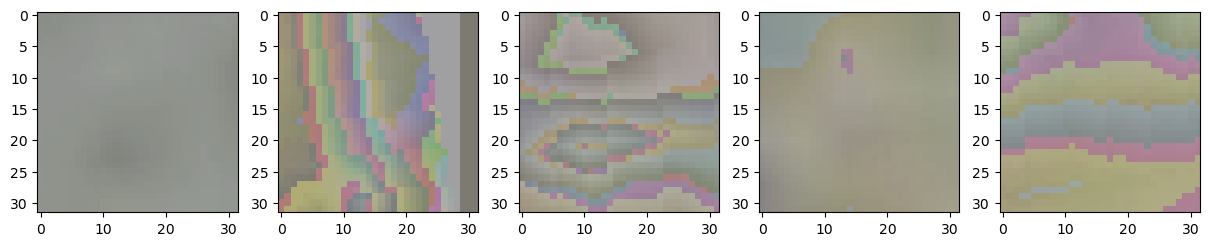

[1, 100] loss: 7.675
[1, 200] loss: 7.664
[1, 300] loss: 7.641
[2, 100] loss: 7.227
[2, 200] loss: 7.208
[2, 300] loss: 7.331
[3, 100] loss: 7.245
[3, 200] loss: 7.151
[3, 300] loss: 7.124
[4, 100] loss: 7.283
[4, 200] loss: 7.299
[4, 300] loss: 7.445
[5, 100] loss: 7.545
[5, 200] loss: 7.354
[5, 300] loss: 7.289
[6, 100] loss: 7.370
[6, 200] loss: 7.639
[6, 300] loss: 7.443
[7, 100] loss: 7.511
[7, 200] loss: 7.569
[7, 300] loss: 7.503
[8, 100] loss: 7.435
[8, 200] loss: 7.422
[8, 300] loss: 7.632
[9, 100] loss: 7.501
[9, 200] loss: 7.508
[9, 300] loss: 7.504
[10, 100] loss: 7.310
[10, 200] loss: 7.313
[10, 300] loss: 7.335
[11, 100] loss: 7.317
[11, 200] loss: 7.340
[11, 300] loss: 7.278
[12, 100] loss: 7.315
[12, 200] loss: 7.474
[12, 300] loss: 7.346
[13, 100] loss: 7.358
[13, 200] loss: 7.322
[13, 300] loss: 7.396
[14, 100] loss: 7.447
[14, 200] loss: 7.437
[14, 300] loss: 7.511
[15, 100] loss: 7.420
[15, 200] loss: 7.320
[15, 300] loss: 7.494
[16, 100] loss: 7.440
[16, 200] loss:

In [5]:
losses = []  # initialize the list outside the loop

# Training Loop
for epoch in range(50):  # Loop over the dataset multiple times
    for i, (data, _) in enumerate(trainloader, 0):
        inputs = data.to(device)

        # Convert tensor to PIL Image and apply the transform
        inputs1 = [contrastive_transform(to_pil_image(img.cpu())) for img in inputs]
        inputs1 = torch.stack(inputs1).to(device)

        inputs2 = [contrastive_transform(to_pil_image(img.cpu())) for img in inputs]
        inputs2 = torch.stack(inputs2).to(device)

        # Visualizing the transformed images
        if i == 0 and epoch == 0:  # Example to plot the first batch of the first epoch
            def denormalize(tensor):
                mean = np.array([0.4914, 0.4822, 0.4465])
                std = np.array([0.2023, 0.1994, 0.2010])
                denormalized = tensor.cpu().numpy() * std[:, None, None] + mean[:, None, None]
                denormalized = np.clip(denormalized, 0, 1)
                return denormalized

            fig, axs = plt.subplots(1, 5, figsize=(15, 5))
            for j in range(5):  # Change this value to plot more or fewer images
                image = denormalize(inputs1[j])
                axs[j].imshow(np.transpose(image, (1, 2, 0)))
            plt.show()

        q = q_encoder(inputs1)
        with torch.no_grad():
            k = k_encoder(inputs2)

        # Compute loss
        loss = contrastive_loss(q, k, queue)

        # Record the loss
        losses.append(loss.item())

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Momentum update for the key encoder
        momentum_update(q_encoder, k_encoder)

        # Update queue
        batch_size = k.size(0)
        if queue_ptr + batch_size <= queue_size:
            queue[:, queue_ptr:queue_ptr+batch_size] = k.T
        else:
            # If the batch wraps around the end of the queue
            size_before_wrap = queue_size - queue_ptr
            size_after_wrap = batch_size - size_before_wrap
            queue[:, queue_ptr:] = k.T[:, :size_before_wrap]
            queue[:, :size_after_wrap] = k.T[:, size_before_wrap:]
        queue_ptr = (queue_ptr + batch_size) % queue_size

        # Print statistics
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}")



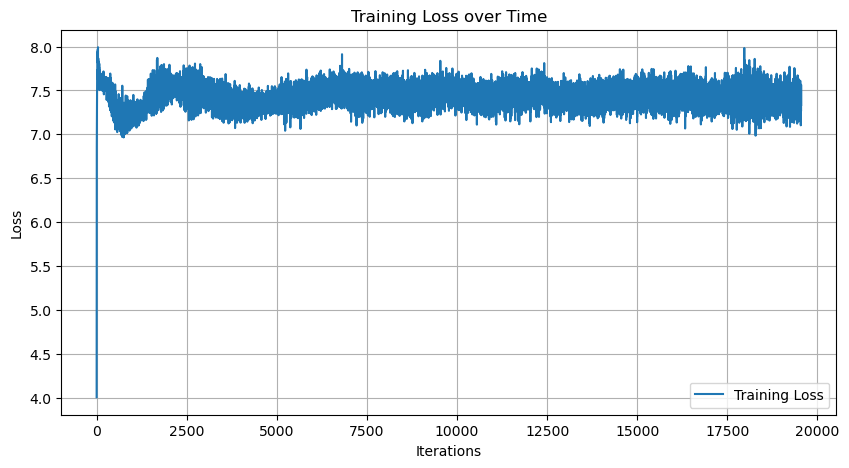

In [6]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10,5))
# plt.title("Training Loss over Time")
# plt.plot(losses)
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.show()


# Enhanced Loss Plot
plt.figure(figsize=(10, 5))
plt.title("Training Loss over Time")
plt.plot(losses, label='Training Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()



In [7]:
for param in q_encoder.parameters():
    param.requires_grad = False


# # Unfreeze some layers of the encoder for fine-tuning if required
# for param in q_encoder.conv.parameters():  # Example to unfreeze the conv layer
#     param.requires_grad = True


In [8]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified


In [9]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(128, num_classes)  # Assuming encoder output size is 128

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

model = Classifier(q_encoder, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

for epoch in range(50):
    for i, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}")




[1, 100] loss: 2.296
[1, 200] loss: 2.277
[1, 300] loss: 2.268
[2, 100] loss: 2.255
[2, 200] loss: 2.249
[2, 300] loss: 2.236
[3, 100] loss: 2.206
[3, 200] loss: 2.201
[3, 300] loss: 2.211
[4, 100] loss: 2.202
[4, 200] loss: 2.199
[4, 300] loss: 2.165
[5, 100] loss: 2.161
[5, 200] loss: 2.198
[5, 300] loss: 2.197
[6, 100] loss: 2.121
[6, 200] loss: 2.182
[6, 300] loss: 2.131
[7, 100] loss: 2.127
[7, 200] loss: 2.078
[7, 300] loss: 2.126
[8, 100] loss: 2.064
[8, 200] loss: 2.116
[8, 300] loss: 2.096
[9, 100] loss: 2.137
[9, 200] loss: 2.164
[9, 300] loss: 2.069
[10, 100] loss: 2.144
[10, 200] loss: 2.123
[10, 300] loss: 2.074
[11, 100] loss: 2.094
[11, 200] loss: 2.131
[11, 300] loss: 2.078
[12, 100] loss: 2.043
[12, 200] loss: 2.062
[12, 300] loss: 1.982
[13, 100] loss: 2.044
[13, 200] loss: 2.047
[13, 300] loss: 2.074
[14, 100] loss: 2.011
[14, 200] loss: 2.080
[14, 300] loss: 2.047
[15, 100] loss: 2.057
[15, 200] loss: 2.048
[15, 300] loss: 2.140
[16, 100] loss: 2.058
[16, 200] loss:

NameError: name 'confusion_matrix' is not defined

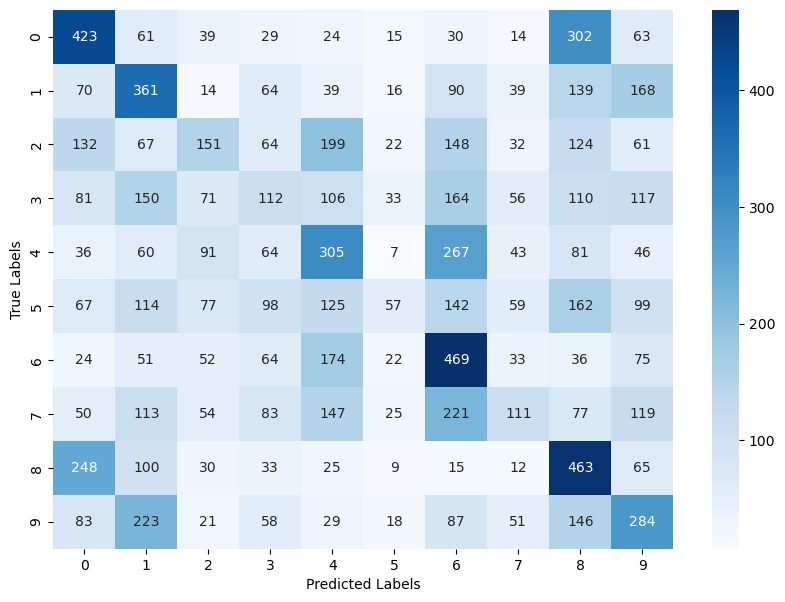

              precision    recall  f1-score   support

           0       0.35      0.42      0.38      1000
           1       0.28      0.36      0.31      1000
           2       0.25      0.15      0.19      1000
           3       0.17      0.11      0.13      1000
           4       0.26      0.30      0.28      1000
           5       0.25      0.06      0.09      1000
           6       0.29      0.47      0.36      1000
           7       0.25      0.11      0.15      1000
           8       0.28      0.46      0.35      1000
           9       0.26      0.28      0.27      1000

    accuracy                           0.27     10000
   macro avg       0.26      0.27      0.25     10000
weighted avg       0.26      0.27      0.25     10000

Accuracy of the network on the test images: 27 %


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cm = confusion_matrix(all_labels, all_predictions)

# 2. Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 3. Compute other metrics
print(classification_report(all_labels, all_predictions))        
        

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
